# Data Analysis of the House Prices datasets

In this notebook, we are going to to analyse the different variables of the House Prices Daset from the Kaggle Competition: [House Prices: Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)

In [35]:
# === System imports ===
import csv
sys.path.append("../../")

# === Third-party import ===

# To handle datasets
import pandas as pd
import numpy as np
from scipy import stats
# To split the dataset
from sklearn.model_selection import train_test_split
# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To display only a limited number of columns of the dataframe in the whole notebook
pd.options.display.max_rows = 1000

# === Local imports ===
import utils
import feature_engineering

root = utils.get_project_root()


## Load data

- Import the most relevant variables
- Import the dataset and focus on the `most_relevant_variables`

In [36]:
most_relevant_variables = utils.import_list(file_path=f'{root}/datasets/outputs/most_relevant_variables.csv')

most_relevant_variables

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageArea',
 'TotalBsmtSF',
 'FullBath',
 'TotRmsAbvGrd']

In [37]:
data = pd.read_csv(filepath_or_buffer=f'{root}/datasets/inputs/train.csv')

target = 'SalePrice'
data = data[most_relevant_variables]
data.head()

,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,TotRmsAbvGrd
0,208500,7,1710,548,856,2,8
1,181500,6,1262,460,1262,2,6
2,223500,7,1786,608,920,2,6
3,140000,7,1717,642,756,1,7
4,250000,8,2198,836,1145,2,9


In [38]:
data.shape

(1460, 7)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalePrice     1460 non-null   int64
 1   OverallQual   1460 non-null   int64
 2   GrLivArea     1460 non-null   int64
 3   GarageArea    1460 non-null   int64
 4   TotalBsmtSF   1460 non-null   int64
 5   FullBath      1460 non-null   int64
 6   TotRmsAbvGrd  1460 non-null   int64
dtypes: int64(7)
memory usage: 80.0 KB


#### Observation

The dataset with only the `most_relevant_variables` contains no missing values

## Split the dataset into train and test

Before beginning to engineer our features, it is important to separate our data intro training and testing set.

**We set the seed to be 0**## Split the dataset into train and test

Before beginning to engineer our features, it is important to separate our data intro training and testing set.

**We set the seed to be 0**

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data, data[target], 
                                                          test_size=0.1, 
                                                          random_state=0)
for dataset in ['X_train', 'X_test', 'y_train', 'y_test']:
    print(f'{dataset}: {eval(dataset).shape}')

X_train: (1314, 7)
X_test: (146, 7)
y_train: (1314,)
y_test: (146,)


## Numerical variables

In [41]:
numerical_variables = ['GrLivArea', 'GarageArea', 'TotalBsmtSF']
data_numerical = data[numerical_variables]

### Outliers

[Reference](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba): *Ways to Detect and Remove the Outliers*
 
 To have a better visualization of outliers let's display the **Bobplot** of the numerical variables


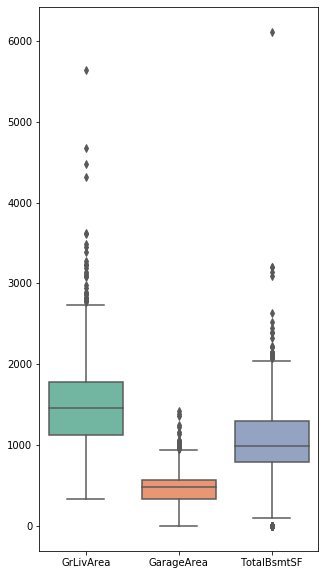

In [42]:
plt.figure(figsize=(5,10))
ax = sns.boxplot(data=data_numerical, orient="v", palette="Set2")

#### Z-score

Let's try to remove some of these outliers with the **z-score** strategy: removing all rows containing at least one variable above the thrshold z-score. <br>Usually we choose a **threshold=3** standard deviations.

We can see the influence of the threshold on the data remove by plotting: <br>
```f(threshold) = %rows removed from initial dataset```

2.0


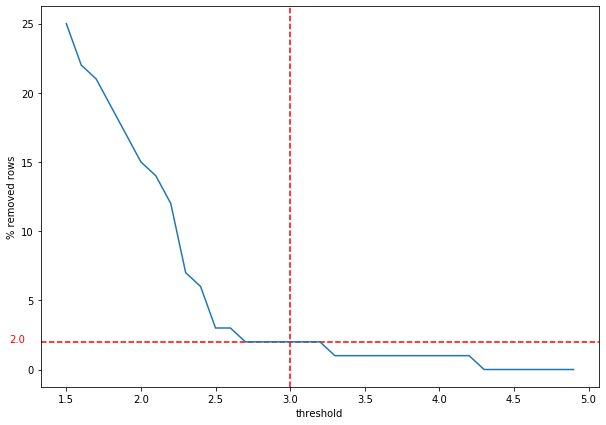

In [43]:
z = np.abs(stats.zscore(data_numerical))
thresholds = np.around(np.arange(1.5, 5.0, 0.1), 2)
percents_removed_rows = []
for threshold in thresholds:
    cleaned_data_numerical = data_numerical[(z < threshold).all(axis=1)]
    percent_removed_rows = round(1 - len(cleaned_data_numerical)/len(data_numerical), 2) * 100
    if threshold == 3.0:
        percent_removed_rows_3 = percent_removed_rows
    cleaned_data_numerical = data_numerical[(z < threshold).all(axis=1)]
    percents_removed_rows.append(percent_removed_rows)


print(percent_removed_rows_3)
plt.figure(figsize=(10, 7))
plt.axvline(x=3, linestyle='--', color='red')
plt.axhline(y=percent_removed_rows_3, linestyle='--', color='red')
plt.text(x=1.12, y=percent_removed_rows_3, s=f'{round(percent_removed_rows_3, 2)}', color = 'red')
plt.xlabel('threshold')
plt.ylabel(f'% removed rows')
ax = plt.plot(thresholds, percents_removed_rows)



By choosing *threshold = 3*, we remove 2% of the rows of the dataframe

#### IQR score

The boxplot displayed further up uses the **IQR mehod**.

Let's see the percentage of removed rows with the standard parameters.

In [44]:
Q1 = data_numerical.quantile(0.25)
Q3 = data_numerical.quantile(0.75)
IQR = Q3 - Q1
is_outlier = (data_numerical < (Q1 - 1.5 * IQR)) | (data_numerical > (Q3 + 1.5 * IQR))
cleaned_data = data_numerical[~is_outlier.any(axis=1)]
print(f"The % of removed rows is {round((1 - len(cleaned_data)/len(data_numerical))*100, 2)}")

The % of removed rows is 6.85


**IQR scoring** seams to be more robust to outliers, as it removes more rows than with **z-scoring**

#### Remove outliers from X_train

We are going to keep the rows reulsting from IQR in `X_train`

In [45]:
print(f"X_train size with outliers: {X_train.shape}")
X_train = feature_engineering.remove_outliers(df=X_train, numerical_variables=numerical_variables)
print(f"X_train size without outliers: {X_train.shape}")

X_train size with outliers: (1314, 7)
X_train size without outliers: (1226, 7)


### Distribution

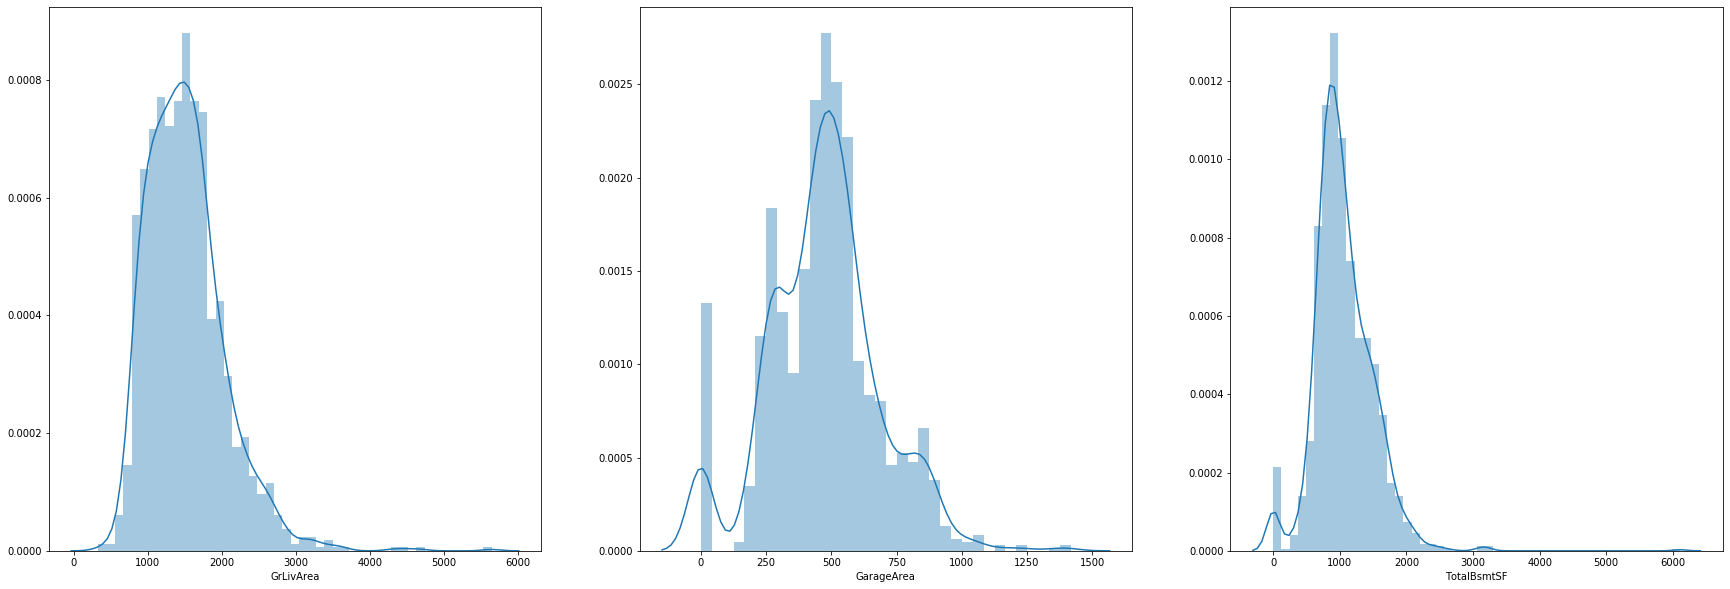

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

for var, ax in zip(numerical_variables, axes.flat):
    sns.distplot(data[var], ax=ax)


Similarily to `SalePrice`, these variables seem to have some skewness.

In [47]:
for var in numerical_variables:
    if any(data[var]==0):
        print(f"{var} contains zero values")

GarageArea contains zero values
TotalBsmtSF contains zero values


Unfortunately the variables: `GarageArea` and `TotalBsmtSF` have null variables in the case where the house has no garage or basement. This makes the logarithmic transformation impossible.

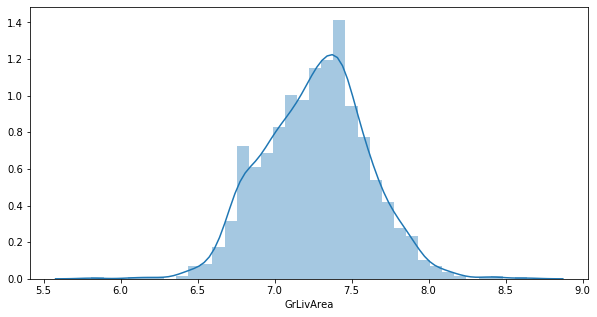

In [48]:
plt.figure(figsize=(10,5))
sns.distplot(np.log(data['GrLivArea']))

However, log-transforming `GrLivArea` can be useful, as well as the target variable `SalePrice`

We are going to make this transformation for `X_train` and `X_test`

In [49]:
for var in ['GrLivArea', 'SalePrice']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

## Categorical variables

In [50]:
categorical_variables = ['OverallQual', 'FullBath', 'TotRmsAbvGrd']
data_categorical = data[categorical_variables]

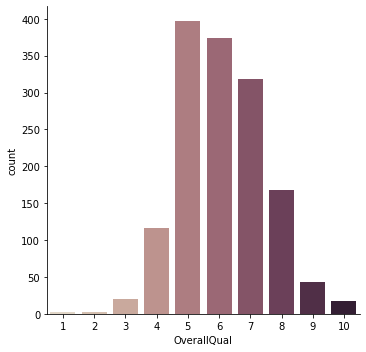

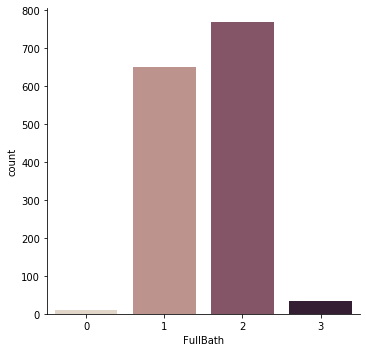

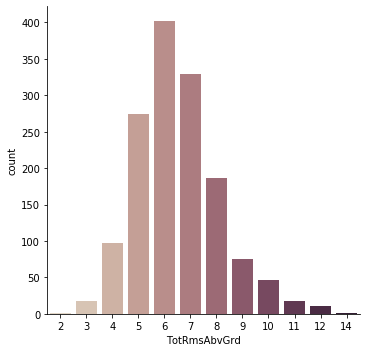

In [51]:
for var in categorical_variables:
    sns.catplot(data=data_categorical, 
            x=var,
            kind="count",
            palette="ch:.25")

#### Observations

- The categorical variables: `OverallQual` and `TotRmsGrd` can be seen as **ordinal variables** since they take values that can be ordered.
By displaying this catplot, we can see that similarily to numerical variables, these ordinal variables are "normally distributed" (even if this term applies to munerical variables).
- The extreme values seem to be quite rare and are the equivalents of **outliers for numerical variables. We can call them **Rare labels**

### Group rare labels

Let's gather these rare labels under the same lable name **Rare**.
We will call rare labels for a categorical variable, a label that is shared by less than 1% of the instances.

In [52]:
for var in categorical_variables:
    # Percentage occurency
    per_occ = data_categorical[var].value_counts()/len(data_categorical)
    # Find rare labels
    rare_labels = per_occ[per_occ<0.01].index.tolist()
    # Transform the dataframe
    data_categorical[var] = np.where(data_categorical[var].isin(rare_labels), 
                                    'Rare',
                                    data_categorical[var])

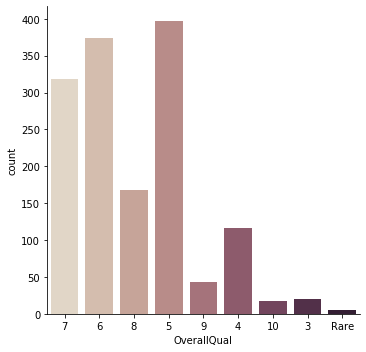

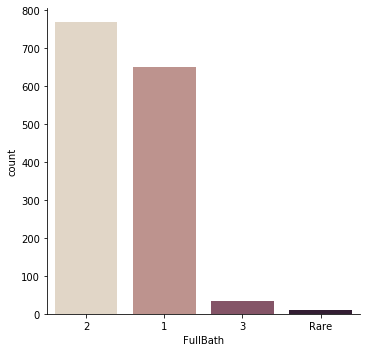

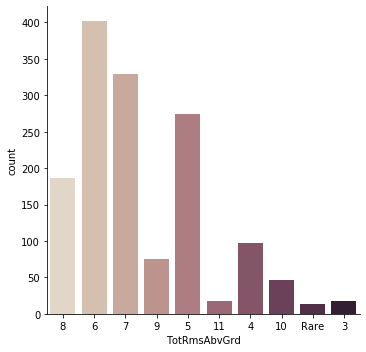

In [53]:
for var in categorical_variables:
    sns.catplot(data=data_categorical, 
            x=var,
            kind="count",
            palette="ch:.25")

Let's apply this transformation to `X_train` and `X_test`

In [54]:
X_train = feature_engineering.replace_rare_labels(X_train, 
                    categorical_variables=categorical_variables)
X_test = feature_engineering.replace_rare_labels(X_test, 
                    categorical_variables=categorical_variables)

### On-hot-encoding

We are going to **one-hot-encode** the categorical variables. We will drop one of labels as it is dependant of all the others.<br>
We are going to tranform `X_train` and `X_test`

In [55]:
X_train = pd.get_dummies(data= X_train, columns=categorical_variables, drop_first=True)
print(f'X_train shape: {X_train.shape}')
X_test = pd.get_dummies(data= X_test, columns=categorical_variables, drop_first=True)
print(f'X_test shape: {X_test.shape}')


X_train shape: (1226, 21)
X_test shape: (146, 22)


`X_test` has a different number of columns than `X_train`.<br>
Before going further, we must ensure that the two dataframes have the same columns.

In [56]:
common_vars, vars_X_train_not_X_test, vars_X_test_not_X_train = feature_engineering.summarize_common_variables(df1=X_train, 
                                                                                                df2=X_test)


In common: 19
['SalePrice', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'FullBath_2', 'FullBath_3', 'FullBath_Rare', 'TotRmsAbvGrd_4', 'TotRmsAbvGrd_5', 'TotRmsAbvGrd_6', 'TotRmsAbvGrd_7', 'TotRmsAbvGrd_8', 'TotRmsAbvGrd_9', 'TotRmsAbvGrd_Rare']


In df1 and not in df2: 2
['OverallQual_Rare', 'TotRmsAbvGrd_3']


In df2 and not in df1: 3
['OverallQual_3', 'OverallQual_4', 'TotRmsAbvGrd_12']


#### Observations

- 5 variables are present in one dataframe and not the other one. It is aproximatively 1/5 of the variables: 5 out of 24!
- All these variables are **One-Hot-Encoded**

It is due to the 'Rare' labels selection.
For now, let's adopt a brute-force approach and add columns of 0s for the missing variables in `X_train` and `X_test` so that their columns match


In [57]:
X_train = feature_engineering.complete_one_hot_variables(df=X_train,
                                                         var_names=vars_X_test_not_X_train)
X_test = feature_engineering.complete_one_hot_variables(df=X_test,
                                                        var_names=vars_X_train_not_X_test)  

# Print the summary again 
common_vars, vars_X_train_not_X_test, vars_X_test_not_X_train = feature_engineering.summarize_common_variables(df1=X_train, 
                                                                                                df2=X_test)  

print('\nShapes:') 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')                                                   

In common: 24
['SalePrice', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'OverallQual_5', 'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallQual_Rare', 'FullBath_2', 'FullBath_3', 'FullBath_Rare', 'TotRmsAbvGrd_3', 'TotRmsAbvGrd_4', 'TotRmsAbvGrd_5', 'TotRmsAbvGrd_6', 'TotRmsAbvGrd_7', 'TotRmsAbvGrd_8', 'TotRmsAbvGrd_9', 'TotRmsAbvGrd_Rare', 'OverallQual_3', 'OverallQual_4', 'TotRmsAbvGrd_12']


In df1 and not in df2: 0
[]


In df2 and not in df1: 0
[]

Shapes:
X_train shape: (1226, 24)
X_test shape: (146, 24)


### Save the engineered dateframes

In [58]:
X_train.to_csv(path_or_buf=f'{root}/datasets/outputs/with_main_variables/x_train.csv')
X_test.to_csv(path_or_buf=f'{root}/datasets/outputs/with_main_variables/x_test.csv')